# **Vision Transformer (ViT)**

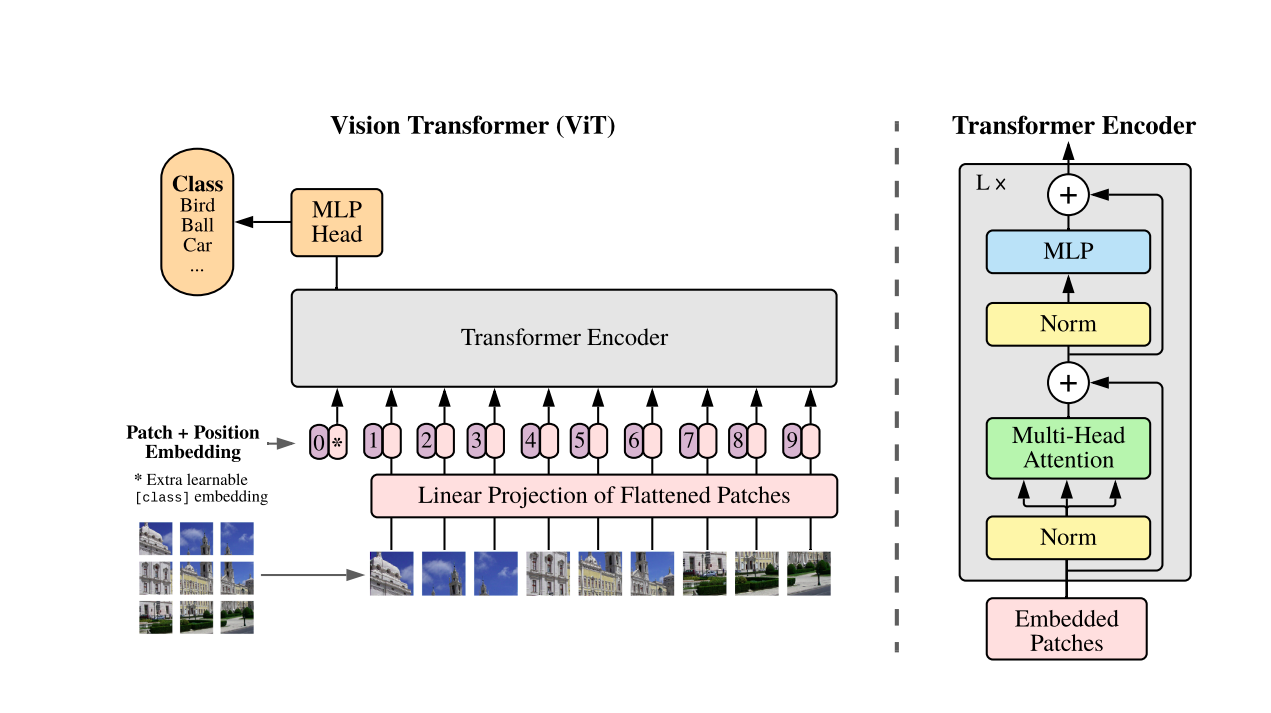

In [ ]:
import torch
from torch import nn
from torchsummary import summary

# Parameters

input_dim  = 1
embed_dim  = 16
patch_size  = 4
num_patches = 49
dropout =  0.01
image_width = 28
image_height = 28
batch_size = 512
nheads = 8
num_layers = 2
num_classes = 20
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:

class PatchEmbedding(nn.Module):
    def __init__(self,input_dim,embed_dim,patch_size,num_patches,dropout):
        super().__init__()
        self.patcher = nn.Sequential(
            nn.Conv2d(input_dim,
                      embed_dim,
                      kernel_size=patch_size,
                      stride=patch_size),
            nn.Flatten(2)
        )
        self.cls_token = nn.Parameter(torch.rand(size = (1,input_dim, embed_dim)),requires_grad=True)
        self.postional_encoding  =  nn.Parameter(torch.rand(size = (1,num_patches+1, embed_dim)),requires_grad=True)
        self.dropout = nn.Dropout(dropout)

    def forward(self,x):
        cls_token  = self.cls_token.expand(x.shape[0],-1,-1)
        x = self.patcher(x).permute(0,2,1)
        x = torch.cat([cls_token,x],dim = 1)
        x = self.postional_encoding + x
        x = self.dropout(x)
        return x

In [ ]:
class ViT(nn.Module):
    def __init__(self):
        super().__init__()
        self.patch_embedding = PatchEmbedding(input_dim,embed_dim,patch_size,num_patches,dropout)
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=nheads, dropout=dropout, activation='gelu', batch_first=True, norm_first=True)
        self.encoder = nn.TransformerEncoder(encoder_layer=encoder_layer, num_layers=num_layers)
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(normalized_shape=embed_dim),
            nn.Linear(in_features=embed_dim,out_features=num_classes)
        )

    def forward(self,x):
        x = self.patch_embedding(x)
        x = self.encoder(x)
        x = self.mlp_head(x[:, 0 ,:])
        return x


In [ ]:
model  = ViT().to(device)
print(model(torch.randn(size = (batch_size,input_dim,image_width,image_height))).shape)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


torch.Size([512, 20])


In [ ]:
print(model)

ViT(
  (patch_embedding): PatchEmbedding(
    (patcher): Sequential(
      (0): Conv2d(1, 16, kernel_size=(4, 4), stride=(4, 4))
      (1): Flatten(start_dim=2, end_dim=-1)
    )
    (dropout): Dropout(p=0.01, inplace=False)
  )
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=16, out_features=16, bias=True)
        )
        (linear1): Linear(in_features=16, out_features=2048, bias=True)
        (dropout): Dropout(p=0.01, inplace=False)
        (linear2): Linear(in_features=2048, out_features=16, bias=True)
        (norm1): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.01, inplace=False)
        (dropout2): Dropout(p=0.01, inplace=False)
      )
    )
  )
  (mlp_head): Sequential(
    (0): LayerNorm((16,), eps=1e-05, elem